In [1]:
import pandas as pd
from scipy.stats import zscore
import pandas as pd
from sklearn.preprocessing import StandardScaler

# load packages
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.33)
# N, D = X_train.shape
from datetime import date
import logging
# Configure basic logging to a file
logging.basicConfig(
    filename='experiments.log',  # Name of the log file
    level=logging.INFO,             # Minimum logging level to capture (e.g., INFO, DEBUG, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format of the log messages
    datefmt='%Y-%m-%d %H:%M:%S'      # Format for the timestamp
)

In [2]:
ticker="slv"
#0-> 10, 1->50,2->100
horizon_to_predict=2
look_back_window=100
batch_size=2048


In [ ]:
data_path="data/etf/jan2025/cleaned/"
prefix="_cleaned_jan2025"
df = pd.read_csv(f"{data_path}{ticker}{prefix}.csv",engine="pyarrow",sep = ',')
df["Date-Time"] = pd.to_datetime(df["Date-Time"])
df["Date-Time"] = df["Date-Time"].dt.tz_convert("America/New_York")

In [3]:
# ---- select columns to normalize: all L1–L10 Bid/Ask Price and Size ----
price_cols = [f"L{i}-BidPrice" for i in range(1, 11)] + [f"L{i}-AskPrice" for i in range(1, 11)]
size_cols  = [f"L{i}-BidSize"  for i in range(1, 11)] + [f"L{i}-AskSize"  for i in range(1, 11)]
cols_to_normalize = price_cols + size_cols

# ---- apply z-score normalization ----
scaler = StandardScaler()
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

target_cols = [f"Target_{i}"  for i in [10,50,100]]
df[price_cols + size_cols+target_cols]


,L1-BidPrice,L2-BidPrice,L3-BidPrice,L4-BidPrice,L5-BidPrice,L6-BidPrice,L7-BidPrice,L8-BidPrice,L9-BidPrice,L10-BidPrice,...,L4-AskSize,L5-AskSize,L6-AskSize,L7-AskSize,L8-AskSize,L9-AskSize,L10-AskSize,Target_10,Target_50,Target_100
0,-1.170929,-1.170573,-1.170162,-1.169475,-1.168460,-1.167071,-1.165924,-1.164351,-1.162287,-1.157453,...,-0.006842,-0.522371,-0.561154,-0.613647,0.386100,-0.268494,-0.048030,0,0,0
1,-1.150236,-1.149882,-1.149475,-1.148792,-1.147787,-1.146413,-1.145277,-1.143720,-1.141677,-1.136899,...,4.342381,3.858108,-0.561154,-0.613647,0.386100,-0.268494,-0.048030,0,2,0
2,-1.150236,-1.149882,-1.149475,-1.148792,-1.147787,-1.146413,-1.145277,-1.143720,-1.141677,-1.136899,...,3.548942,3.443739,-0.924329,-0.083797,-0.403254,-0.268494,-0.577182,0,0,0
3,-1.150236,-1.149882,-1.149475,-1.148792,-1.147787,-1.146413,-1.145277,-1.143720,-1.141677,-1.136899,...,4.342381,3.858108,3.917997,-0.613647,0.386100,-0.268494,-0.048030,0,2,0
4,-1.150236,-1.149882,-1.149475,-1.148792,-1.147787,-1.146413,-1.145277,-1.143720,-1.141677,-1.136899,...,3.548942,3.443739,-0.924329,-0.083797,-0.403254,-0.268494,-0.577182,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106169,1.353589,1.353673,1.353685,1.353779,1.353610,1.353265,1.353089,1.352680,1.352190,1.350134,...,0.815984,0.543151,-0.803271,-0.500108,-0.121342,0.028994,-0.400798,2,2,2
106170,1.353589,1.353673,1.353685,1.353779,1.353610,1.353265,1.353089,1.352680,1.352190,1.350134,...,0.257637,-0.522371,-0.833535,-0.424415,-0.177725,0.028994,-0.665374,2,0,2
106171,1.353589,1.353673,1.353685,1.353779,1.353610,1.353265,1.353089,1.352680,1.352190,1.350134,...,0.845370,0.543151,-0.137451,-0.500108,-0.121342,0.028994,0.304737,2,2,2
106172,1.374281,1.374363,1.374373,1.374461,1.374283,1.373924,1.373737,1.373312,1.372801,1.370688,...,0.257637,-0.522371,-0.833535,-0.424415,-0.177725,0.028994,-0.665374,2,0,2


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
df["Date"] = pd.to_datetime(df["Date-Time"]).dt.date
df.groupby(["Date"]).size()

Date
2025-01-03     3091
2025-01-06     5516
2025-01-07     6412
2025-01-08     7171
2025-01-10     9715
2025-01-13     5359
2025-01-14     5024
2025-01-15     6418
2025-01-16     4973
2025-01-17     3398
2025-01-21     3581
2025-01-22     2582
2025-01-23     3242
2025-01-24     4269
2025-01-27     4396
2025-01-28     4010
2025-01-29    10478
2025-01-30     6163
2025-01-31    10376
dtype: int64

In [6]:
df_train = df[(df["Date"] >= date(2025, 1, 3)) & (df["Date"] <= date(2025, 1, 10))]
df_val = df[(df["Date"] >= date(2025, 1, 25)) & (df["Date"] <= date(2025, 1, 27))]
df_test = df[(df["Date"] >= date(2025, 1, 28)) & (df["Date"] <= date(2025, 1, 31))]

In [7]:
df_train = df_train[price_cols + size_cols+target_cols]
df_test =  df_test[price_cols + size_cols+target_cols]
df_val = df_val[price_cols + size_cols+target_cols]

In [8]:
from models.dataset import Dataset as Dataset

dataset_train = Dataset(data=df_train.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)
dataset_val = Dataset(data=df_train.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)
dataset_test = Dataset(data=df_train.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape)

torch.Size([31806, 1, 100, 40]) torch.Size([31806])


In [9]:
from models.deeplob import deeplob as deeplob
model = deeplob(device=device,y_len = dataset_train.num_classes)
model.to(device)

deeplob(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): Tanh()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): Tanh()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model_savepoint=f"best_val_model_{ticker}_deeplob.pt"

In [11]:
from models.gd import GradientDescent as GradientDescent
train_losses, val_losses = GradientDescent(device).batch(model, criterion, optimizer,
                                    train_loader, val_loader,model_savepoint, epochs=50)
all_targets, all_predictions = GradientDescent(device).evaulate_model(model_savepoint, model, test_loader)

  2%|▏         | 1/50 [00:03<02:30,  3.07s/it]

model saved
Epoch 1/50, Train Loss: 1.0911,               Validation Loss: 1.0963, Duration: 0:00:03.071290, Best Val Epoch: 0


  4%|▍         | 2/50 [00:06<02:23,  2.99s/it]

model saved
Epoch 2/50, Train Loss: 1.0724,               Validation Loss: 1.0772, Duration: 0:00:02.935020, Best Val Epoch: 1


  6%|▌         | 3/50 [00:08<02:18,  2.95s/it]

model saved
Epoch 3/50, Train Loss: 1.0511,               Validation Loss: 1.0447, Duration: 0:00:02.908037, Best Val Epoch: 2


  8%|▊         | 4/50 [00:11<02:17,  2.99s/it]

model saved
Epoch 4/50, Train Loss: 1.0269,               Validation Loss: 1.0155, Duration: 0:00:03.043040, Best Val Epoch: 3


 10%|█         | 5/50 [00:15<02:15,  3.01s/it]

model saved
Epoch 5/50, Train Loss: 1.0011,               Validation Loss: 0.9870, Duration: 0:00:03.041867, Best Val Epoch: 4


 12%|█▏        | 6/50 [00:17<02:11,  2.99s/it]

model saved
Epoch 6/50, Train Loss: 0.9751,               Validation Loss: 0.9662, Duration: 0:00:02.949576, Best Val Epoch: 5


 14%|█▍        | 7/50 [00:21<02:15,  3.14s/it]

model saved
Epoch 7/50, Train Loss: 0.9512,               Validation Loss: 0.9381, Duration: 0:00:03.454761, Best Val Epoch: 6


 16%|█▌        | 8/50 [00:24<02:12,  3.15s/it]

model saved
Epoch 8/50, Train Loss: 0.9274,               Validation Loss: 0.9143, Duration: 0:00:03.155881, Best Val Epoch: 7


 18%|█▊        | 9/50 [00:27<02:08,  3.13s/it]

model saved
Epoch 9/50, Train Loss: 0.9052,               Validation Loss: 0.8960, Duration: 0:00:03.102882, Best Val Epoch: 8


 20%|██        | 10/50 [00:30<02:02,  3.05s/it]

model saved
Epoch 10/50, Train Loss: 0.8854,               Validation Loss: 0.8785, Duration: 0:00:02.880670, Best Val Epoch: 9


 22%|██▏       | 11/50 [00:33<01:57,  3.01s/it]

model saved
Epoch 11/50, Train Loss: 0.8665,               Validation Loss: 0.8580, Duration: 0:00:02.896981, Best Val Epoch: 10


 24%|██▍       | 12/50 [00:36<01:54,  3.01s/it]

model saved
Epoch 12/50, Train Loss: 0.8517,               Validation Loss: 0.8468, Duration: 0:00:03.001696, Best Val Epoch: 11


 26%|██▌       | 13/50 [00:39<01:50,  2.99s/it]

model saved
Epoch 13/50, Train Loss: 0.8348,               Validation Loss: 0.8266, Duration: 0:00:02.959761, Best Val Epoch: 12


 28%|██▊       | 14/50 [00:42<01:47,  2.99s/it]

model saved
Epoch 14/50, Train Loss: 0.8221,               Validation Loss: 0.8234, Duration: 0:00:02.992864, Best Val Epoch: 13


 30%|███       | 15/50 [00:45<01:45,  3.01s/it]

model saved
Epoch 15/50, Train Loss: 0.8094,               Validation Loss: 0.8039, Duration: 0:00:03.044484, Best Val Epoch: 14


 32%|███▏      | 16/50 [00:48<01:43,  3.03s/it]

model saved
Epoch 16/50, Train Loss: 0.8011,               Validation Loss: 0.7956, Duration: 0:00:03.080879, Best Val Epoch: 15


 34%|███▍      | 17/50 [00:51<01:39,  3.03s/it]

model saved
Epoch 17/50, Train Loss: 0.7882,               Validation Loss: 0.7868, Duration: 0:00:03.028789, Best Val Epoch: 16


 36%|███▌      | 18/50 [00:54<01:37,  3.06s/it]

model saved
Epoch 18/50, Train Loss: 0.7809,               Validation Loss: 0.7760, Duration: 0:00:03.118678, Best Val Epoch: 17


 38%|███▊      | 19/50 [00:57<01:33,  3.02s/it]

model saved
Epoch 19/50, Train Loss: 0.7733,               Validation Loss: 0.7675, Duration: 0:00:02.936089, Best Val Epoch: 18


 40%|████      | 20/50 [01:00<01:29,  2.99s/it]

model saved
Epoch 20/50, Train Loss: 0.7671,               Validation Loss: 0.7649, Duration: 0:00:02.909910, Best Val Epoch: 19


 42%|████▏     | 21/50 [01:03<01:25,  2.96s/it]

model saved
Epoch 21/50, Train Loss: 0.7605,               Validation Loss: 0.7568, Duration: 0:00:02.901342, Best Val Epoch: 20


 44%|████▍     | 22/50 [01:06<01:22,  2.94s/it]

model saved
Epoch 22/50, Train Loss: 0.7523,               Validation Loss: 0.7523, Duration: 0:00:02.873877, Best Val Epoch: 21


 46%|████▌     | 23/50 [01:09<01:18,  2.90s/it]

model saved
Epoch 23/50, Train Loss: 0.7475,               Validation Loss: 0.7412, Duration: 0:00:02.816139, Best Val Epoch: 22


 48%|████▊     | 24/50 [01:12<01:17,  2.97s/it]

Epoch 24/50, Train Loss: 0.7411,               Validation Loss: 0.7443, Duration: 0:00:03.142530, Best Val Epoch: 22


 50%|█████     | 25/50 [01:15<01:13,  2.95s/it]

model saved
Epoch 25/50, Train Loss: 0.7364,               Validation Loss: 0.7352, Duration: 0:00:02.894044, Best Val Epoch: 24


 52%|█████▏    | 26/50 [01:18<01:10,  2.94s/it]

Epoch 26/50, Train Loss: 0.7342,               Validation Loss: 0.7417, Duration: 0:00:02.902379, Best Val Epoch: 24


 54%|█████▍    | 27/50 [01:21<01:08,  2.96s/it]

model saved
Epoch 27/50, Train Loss: 0.7308,               Validation Loss: 0.7280, Duration: 0:00:03.010496, Best Val Epoch: 26


 56%|█████▌    | 28/50 [01:23<01:04,  2.94s/it]

model saved
Epoch 28/50, Train Loss: 0.7256,               Validation Loss: 0.7200, Duration: 0:00:02.909709, Best Val Epoch: 27


 58%|█████▊    | 29/50 [01:26<01:01,  2.91s/it]

Epoch 29/50, Train Loss: 0.7220,               Validation Loss: 0.7207, Duration: 0:00:02.842108, Best Val Epoch: 27


 60%|██████    | 30/50 [01:29<00:58,  2.95s/it]

model saved
Epoch 30/50, Train Loss: 0.7212,               Validation Loss: 0.7189, Duration: 0:00:03.034084, Best Val Epoch: 29


 62%|██████▏   | 31/50 [01:32<00:55,  2.92s/it]

model saved
Epoch 31/50, Train Loss: 0.7177,               Validation Loss: 0.7177, Duration: 0:00:02.861697, Best Val Epoch: 30


 64%|██████▍   | 32/50 [01:35<00:52,  2.90s/it]

model saved
Epoch 32/50, Train Loss: 0.7142,               Validation Loss: 0.7154, Duration: 0:00:02.861322, Best Val Epoch: 31


 66%|██████▌   | 33/50 [01:38<00:49,  2.94s/it]

model saved
Epoch 33/50, Train Loss: 0.7122,               Validation Loss: 0.7126, Duration: 0:00:03.005003, Best Val Epoch: 32


 68%|██████▊   | 34/50 [01:41<00:48,  3.04s/it]

Epoch 34/50, Train Loss: 0.7104,               Validation Loss: 0.7203, Duration: 0:00:03.281404, Best Val Epoch: 32


 70%|███████   | 35/50 [01:44<00:45,  3.04s/it]

model saved
Epoch 35/50, Train Loss: 0.7092,               Validation Loss: 0.7052, Duration: 0:00:03.028969, Best Val Epoch: 34


 72%|███████▏  | 36/50 [01:47<00:41,  3.00s/it]

Epoch 36/50, Train Loss: 0.7058,               Validation Loss: 0.7077, Duration: 0:00:02.903857, Best Val Epoch: 34


 74%|███████▍  | 37/50 [01:50<00:38,  2.96s/it]

model saved
Epoch 37/50, Train Loss: 0.7041,               Validation Loss: 0.7006, Duration: 0:00:02.876209, Best Val Epoch: 36


 76%|███████▌  | 38/50 [01:53<00:35,  2.94s/it]

model saved
Epoch 38/50, Train Loss: 0.7022,               Validation Loss: 0.6975, Duration: 0:00:02.876064, Best Val Epoch: 37


 78%|███████▊  | 39/50 [01:56<00:32,  2.95s/it]

Epoch 39/50, Train Loss: 0.6995,               Validation Loss: 0.7046, Duration: 0:00:02.995698, Best Val Epoch: 37


 80%|████████  | 40/50 [01:59<00:29,  2.97s/it]

Epoch 40/50, Train Loss: 0.7020,               Validation Loss: 0.7061, Duration: 0:00:02.992206, Best Val Epoch: 37


 82%|████████▏ | 41/50 [02:02<00:26,  2.99s/it]

Epoch 41/50, Train Loss: 0.6975,               Validation Loss: 0.6984, Duration: 0:00:03.046479, Best Val Epoch: 37


 84%|████████▍ | 42/50 [02:05<00:23,  2.94s/it]

model saved
Epoch 42/50, Train Loss: 0.6951,               Validation Loss: 0.6916, Duration: 0:00:02.827463, Best Val Epoch: 41


 86%|████████▌ | 43/50 [02:08<00:20,  2.92s/it]

Epoch 43/50, Train Loss: 0.6944,               Validation Loss: 0.6933, Duration: 0:00:02.880805, Best Val Epoch: 41


 88%|████████▊ | 44/50 [02:11<00:17,  2.94s/it]

model saved
Epoch 44/50, Train Loss: 0.6906,               Validation Loss: 0.6879, Duration: 0:00:02.975805, Best Val Epoch: 43


 90%|█████████ | 45/50 [02:14<00:14,  2.93s/it]

model saved
Epoch 45/50, Train Loss: 0.6901,               Validation Loss: 0.6879, Duration: 0:00:02.912185, Best Val Epoch: 44


 92%|█████████▏| 46/50 [02:17<00:11,  2.93s/it]

Epoch 46/50, Train Loss: 0.6912,               Validation Loss: 0.6986, Duration: 0:00:02.933615, Best Val Epoch: 44


 94%|█████████▍| 47/50 [02:19<00:08,  2.90s/it]

Epoch 47/50, Train Loss: 0.6919,               Validation Loss: 0.6951, Duration: 0:00:02.827183, Best Val Epoch: 44


 96%|█████████▌| 48/50 [02:22<00:05,  2.91s/it]

Epoch 48/50, Train Loss: 0.6936,               Validation Loss: 0.6984, Duration: 0:00:02.919357, Best Val Epoch: 44


 98%|█████████▊| 49/50 [02:25<00:02,  2.94s/it]

Epoch 49/50, Train Loss: 0.6886,               Validation Loss: 0.6926, Duration: 0:00:03.032463, Best Val Epoch: 44


100%|██████████| 50/50 [02:28<00:00,  2.98s/it]

model saved
Epoch 50/50, Train Loss: 0.6873,               Validation Loss: 0.6844, Duration: 0:00:03.043596, Best Val Epoch: 49


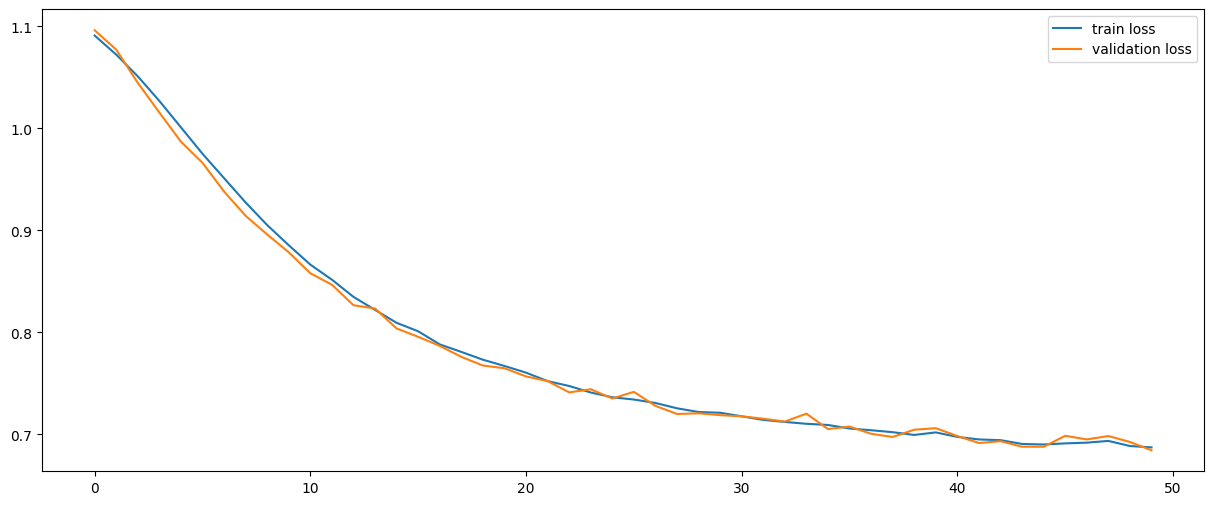

In [12]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

In [13]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.870150286109539
              precision    recall  f1-score   support

           0     0.7649    0.7059    0.7342      7528
           1     0.9068    0.9205    0.9136     12302
           2     0.8922    0.9217    0.9067     11976

    accuracy                         0.8702     31806
   macro avg     0.8547    0.8494    0.8515     31806
weighted avg     0.8677    0.8702    0.8686     31806



In [19]:
from models.mlp import MLP

model = MLP()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model_savepoint='best_val_model_{ticker}_mlp.pt'

In [20]:
train_losses, val_losses = GradientDescent(device).batch(model, criterion, optimizer,
                                    train_loader, val_loader,model_savepoint, epochs=50)

  2%|▏         | 1/50 [00:00<00:38,  1.27it/s]

model saved
Epoch 1/50, Train Loss: 1.0963,               Validation Loss: 1.0955, Duration: 0:00:00.786157, Best Val Epoch: 0


  4%|▍         | 2/50 [00:01<00:39,  1.21it/s]

Epoch 2/50, Train Loss: 1.0964,               Validation Loss: 1.0955, Duration: 0:00:00.852475, Best Val Epoch: 0


  6%|▌         | 3/50 [00:02<00:40,  1.17it/s]

Epoch 3/50, Train Loss: 1.0959,               Validation Loss: 1.0955, Duration: 0:00:00.886581, Best Val Epoch: 0


  8%|▊         | 4/50 [00:03<00:40,  1.14it/s]

Epoch 4/50, Train Loss: 1.0966,               Validation Loss: 1.0955, Duration: 0:00:00.921931, Best Val Epoch: 0


 10%|█         | 5/50 [00:04<00:37,  1.19it/s]

Epoch 5/50, Train Loss: 1.0959,               Validation Loss: 1.0955, Duration: 0:00:00.773889, Best Val Epoch: 0


 12%|█▏        | 6/50 [00:04<00:35,  1.23it/s]

Epoch 6/50, Train Loss: 1.0964,               Validation Loss: 1.0955, Duration: 0:00:00.760224, Best Val Epoch: 0


 14%|█▍        | 7/50 [00:05<00:35,  1.21it/s]

Epoch 7/50, Train Loss: 1.0961,               Validation Loss: 1.0955, Duration: 0:00:00.859015, Best Val Epoch: 0


 16%|█▌        | 8/50 [00:06<00:35,  1.17it/s]

Epoch 8/50, Train Loss: 1.0962,               Validation Loss: 1.0955, Duration: 0:00:00.899584, Best Val Epoch: 0


 18%|█▊        | 9/50 [00:07<00:34,  1.20it/s]

Epoch 9/50, Train Loss: 1.0963,               Validation Loss: 1.0955, Duration: 0:00:00.801206, Best Val Epoch: 0


 20%|██        | 10/50 [00:08<00:34,  1.16it/s]

Epoch 10/50, Train Loss: 1.0964,               Validation Loss: 1.0955, Duration: 0:00:00.914324, Best Val Epoch: 0


 22%|██▏       | 11/50 [00:09<00:33,  1.16it/s]

Epoch 11/50, Train Loss: 1.0962,               Validation Loss: 1.0955, Duration: 0:00:00.872285, Best Val Epoch: 0


 24%|██▍       | 12/50 [00:10<00:31,  1.19it/s]

Epoch 12/50, Train Loss: 1.0963,               Validation Loss: 1.0955, Duration: 0:00:00.776707, Best Val Epoch: 0


 26%|██▌       | 13/50 [00:11<00:31,  1.16it/s]

Epoch 13/50, Train Loss: 1.0963,               Validation Loss: 1.0955, Duration: 0:00:00.921347, Best Val Epoch: 0


 28%|██▊       | 14/50 [00:11<00:30,  1.20it/s]

Epoch 14/50, Train Loss: 1.0964,               Validation Loss: 1.0955, Duration: 0:00:00.769304, Best Val Epoch: 0


 30%|███       | 15/50 [00:12<00:29,  1.18it/s]

Epoch 15/50, Train Loss: 1.0962,               Validation Loss: 1.0955, Duration: 0:00:00.884506, Best Val Epoch: 0


 32%|███▏      | 16/50 [00:13<00:29,  1.14it/s]

Epoch 16/50, Train Loss: 1.0966,               Validation Loss: 1.0955, Duration: 0:00:00.947555, Best Val Epoch: 0


 34%|███▍      | 17/50 [00:14<00:28,  1.16it/s]

Epoch 17/50, Train Loss: 1.0965,               Validation Loss: 1.0955, Duration: 0:00:00.828262, Best Val Epoch: 0


 36%|███▌      | 18/50 [00:15<00:28,  1.14it/s]

Epoch 18/50, Train Loss: 1.0962,               Validation Loss: 1.0955, Duration: 0:00:00.915394, Best Val Epoch: 0


 38%|███▊      | 19/50 [00:16<00:27,  1.12it/s]

Epoch 19/50, Train Loss: 1.0961,               Validation Loss: 1.0955, Duration: 0:00:00.921375, Best Val Epoch: 0


 40%|████      | 20/50 [00:17<00:27,  1.07it/s]

Epoch 20/50, Train Loss: 1.0960,               Validation Loss: 1.0955, Duration: 0:00:01.020619, Best Val Epoch: 0


 42%|████▏     | 21/50 [00:18<00:25,  1.13it/s]

Epoch 21/50, Train Loss: 1.0961,               Validation Loss: 1.0955, Duration: 0:00:00.789503, Best Val Epoch: 0


 44%|████▍     | 22/50 [00:18<00:23,  1.17it/s]

Epoch 22/50, Train Loss: 1.0961,               Validation Loss: 1.0955, Duration: 0:00:00.776745, Best Val Epoch: 0


 46%|████▌     | 23/50 [00:19<00:23,  1.15it/s]

Epoch 23/50, Train Loss: 1.0960,               Validation Loss: 1.0955, Duration: 0:00:00.896716, Best Val Epoch: 0


 48%|████▊     | 24/50 [00:20<00:22,  1.15it/s]

Epoch 24/50, Train Loss: 1.0963,               Validation Loss: 1.0955, Duration: 0:00:00.882403, Best Val Epoch: 0


 50%|█████     | 25/50 [00:21<00:20,  1.19it/s]

Epoch 25/50, Train Loss: 1.0960,               Validation Loss: 1.0955, Duration: 0:00:00.758988, Best Val Epoch: 0


 52%|█████▏    | 26/50 [00:22<00:20,  1.15it/s]

Epoch 26/50, Train Loss: 1.0963,               Validation Loss: 1.0955, Duration: 0:00:00.936259, Best Val Epoch: 0


 54%|█████▍    | 27/50 [00:23<00:20,  1.10it/s]

Epoch 27/50, Train Loss: 1.0963,               Validation Loss: 1.0955, Duration: 0:00:01.008412, Best Val Epoch: 0


 56%|█████▌    | 28/50 [00:24<00:20,  1.10it/s]

Epoch 28/50, Train Loss: 1.0963,               Validation Loss: 1.0955, Duration: 0:00:00.915444, Best Val Epoch: 0


 58%|█████▊    | 29/50 [00:25<00:19,  1.06it/s]

Epoch 29/50, Train Loss: 1.0960,               Validation Loss: 1.0955, Duration: 0:00:01.002434, Best Val Epoch: 0


 60%|██████    | 30/50 [00:26<00:18,  1.11it/s]

Epoch 30/50, Train Loss: 1.0963,               Validation Loss: 1.0955, Duration: 0:00:00.819742, Best Val Epoch: 0


 62%|██████▏   | 31/50 [00:27<00:17,  1.09it/s]

Epoch 31/50, Train Loss: 1.0962,               Validation Loss: 1.0955, Duration: 0:00:00.954849, Best Val Epoch: 0


 64%|██████▍   | 32/50 [00:28<00:16,  1.07it/s]

Epoch 32/50, Train Loss: 1.0962,               Validation Loss: 1.0955, Duration: 0:00:00.962663, Best Val Epoch: 0


 66%|██████▌   | 33/50 [00:28<00:15,  1.10it/s]

Epoch 33/50, Train Loss: 1.0958,               Validation Loss: 1.0955, Duration: 0:00:00.843425, Best Val Epoch: 0


 68%|██████▊   | 34/50 [00:29<00:14,  1.10it/s]

Epoch 34/50, Train Loss: 1.0963,               Validation Loss: 1.0955, Duration: 0:00:00.923103, Best Val Epoch: 0


 70%|███████   | 35/50 [00:30<00:13,  1.10it/s]

Epoch 35/50, Train Loss: 1.0962,               Validation Loss: 1.0955, Duration: 0:00:00.913001, Best Val Epoch: 0


 72%|███████▏  | 36/50 [00:31<00:12,  1.09it/s]

Epoch 36/50, Train Loss: 1.0959,               Validation Loss: 1.0955, Duration: 0:00:00.934198, Best Val Epoch: 0


 74%|███████▍  | 37/50 [00:32<00:11,  1.13it/s]

Epoch 37/50, Train Loss: 1.0965,               Validation Loss: 1.0955, Duration: 0:00:00.797361, Best Val Epoch: 0


 76%|███████▌  | 38/50 [00:33<00:10,  1.18it/s]

Epoch 38/50, Train Loss: 1.0961,               Validation Loss: 1.0955, Duration: 0:00:00.766889, Best Val Epoch: 0


 78%|███████▊  | 39/50 [00:34<00:09,  1.17it/s]

Epoch 39/50, Train Loss: 1.0962,               Validation Loss: 1.0955, Duration: 0:00:00.877709, Best Val Epoch: 0


 80%|████████  | 40/50 [00:34<00:08,  1.16it/s]

Epoch 40/50, Train Loss: 1.0961,               Validation Loss: 1.0955, Duration: 0:00:00.874496, Best Val Epoch: 0


 82%|████████▏ | 41/50 [00:35<00:07,  1.20it/s]

Epoch 41/50, Train Loss: 1.0962,               Validation Loss: 1.0955, Duration: 0:00:00.767607, Best Val Epoch: 0


 84%|████████▍ | 42/50 [00:36<00:06,  1.14it/s]

Epoch 42/50, Train Loss: 1.0963,               Validation Loss: 1.0955, Duration: 0:00:00.966800, Best Val Epoch: 0


 86%|████████▌ | 43/50 [00:37<00:06,  1.13it/s]

Epoch 43/50, Train Loss: 1.0964,               Validation Loss: 1.0955, Duration: 0:00:00.906054, Best Val Epoch: 0


 88%|████████▊ | 44/50 [00:38<00:05,  1.15it/s]

Epoch 44/50, Train Loss: 1.0961,               Validation Loss: 1.0955, Duration: 0:00:00.846865, Best Val Epoch: 0


 90%|█████████ | 45/50 [00:39<00:04,  1.15it/s]

Epoch 45/50, Train Loss: 1.0962,               Validation Loss: 1.0955, Duration: 0:00:00.862035, Best Val Epoch: 0


 92%|█████████▏| 46/50 [00:40<00:03,  1.17it/s]

Epoch 46/50, Train Loss: 1.0964,               Validation Loss: 1.0955, Duration: 0:00:00.811491, Best Val Epoch: 0


 94%|█████████▍| 47/50 [00:41<00:02,  1.15it/s]

Epoch 47/50, Train Loss: 1.0961,               Validation Loss: 1.0955, Duration: 0:00:00.906796, Best Val Epoch: 0


 96%|█████████▌| 48/50 [00:41<00:01,  1.15it/s]

Epoch 48/50, Train Loss: 1.0960,               Validation Loss: 1.0955, Duration: 0:00:00.866474, Best Val Epoch: 0


 98%|█████████▊| 49/50 [00:42<00:00,  1.19it/s]

Epoch 49/50, Train Loss: 1.0964,               Validation Loss: 1.0955, Duration: 0:00:00.781432, Best Val Epoch: 0


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]

Epoch 50/50, Train Loss: 1.0962,               Validation Loss: 1.0955, Duration: 0:00:00.867189, Best Val Epoch: 0


In [21]:
all_targets, all_predictions = GradientDescent(device).evaulate_model(model_savepoint, model, test_loader)

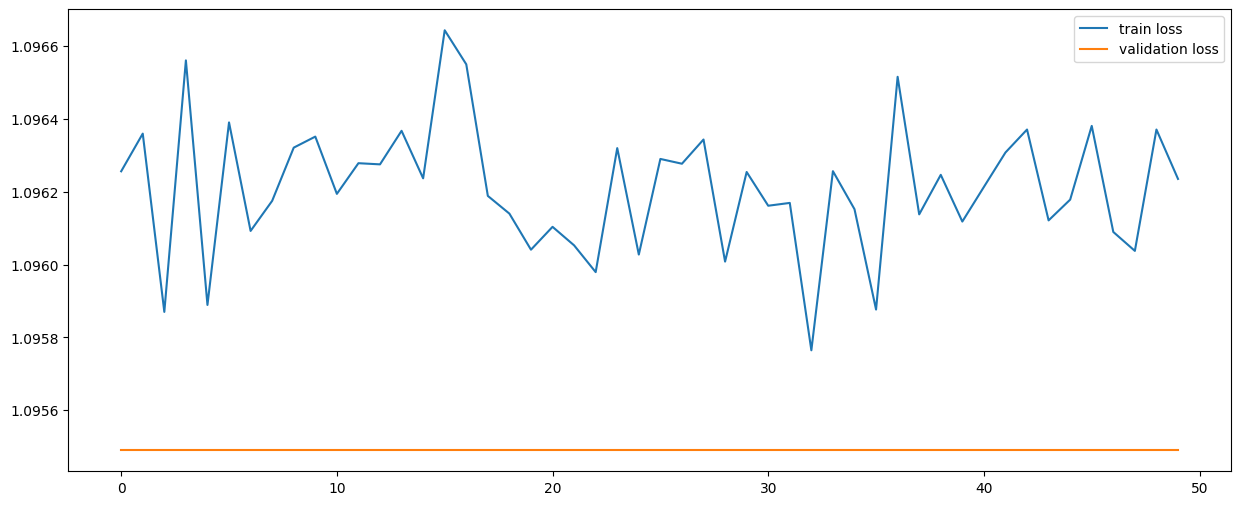

In [22]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

In [23]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.3758410362824624
              precision    recall  f1-score   support

           0     0.2787    0.1051    0.1526      7528
           1     0.3853    0.8682    0.5337     12302
           2     0.3868    0.0402    0.0729     11976

    accuracy                         0.3758     31806
   macro avg     0.3503    0.3379    0.2531     31806
weighted avg     0.3606    0.3758    0.2700     31806



In [37]:
from models.cnn1 import CNN1

model = CNN1(num_classes = dataset_train.num_classes)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model_savepoint='best_val_model_{ticker}_cnn1.pt'
train_losses, val_losses = GradientDescent(device).batch(model, criterion, optimizer,
                                    train_loader, val_loader,model_savepoint, epochs=50)
all_targets, all_predictions = GradientDescent(device).evaulate_model(model_savepoint, model, test_loader)

  2%|▏         | 1/50 [00:00<00:43,  1.14it/s]

model saved
Epoch 1/50, Train Loss: 1.1124,               Validation Loss: 1.1034, Duration: 0:00:00.879837, Best Val Epoch: 0


  4%|▍         | 2/50 [00:01<00:42,  1.14it/s]

model saved
Epoch 2/50, Train Loss: 1.0960,               Validation Loss: 1.0845, Duration: 0:00:00.875100, Best Val Epoch: 1


  6%|▌         | 3/50 [00:02<00:39,  1.20it/s]

model saved
Epoch 3/50, Train Loss: 1.0777,               Validation Loss: 1.0720, Duration: 0:00:00.787744, Best Val Epoch: 2


  8%|▊         | 4/50 [00:03<00:40,  1.13it/s]

model saved
Epoch 4/50, Train Loss: 1.0704,               Validation Loss: 1.0681, Duration: 0:00:00.965323, Best Val Epoch: 3


 10%|█         | 5/50 [00:04<00:39,  1.13it/s]

model saved
Epoch 5/50, Train Loss: 1.0662,               Validation Loss: 1.0642, Duration: 0:00:00.883147, Best Val Epoch: 4


 12%|█▏        | 6/50 [00:05<00:37,  1.19it/s]

model saved
Epoch 6/50, Train Loss: 1.0622,               Validation Loss: 1.0601, Duration: 0:00:00.760329, Best Val Epoch: 5


 14%|█▍        | 7/50 [00:06<00:37,  1.16it/s]

model saved
Epoch 7/50, Train Loss: 1.0580,               Validation Loss: 1.0555, Duration: 0:00:00.901032, Best Val Epoch: 6


 16%|█▌        | 8/50 [00:06<00:35,  1.18it/s]

model saved
Epoch 8/50, Train Loss: 1.0536,               Validation Loss: 1.0496, Duration: 0:00:00.816430, Best Val Epoch: 7


 18%|█▊        | 9/50 [00:07<00:34,  1.20it/s]

model saved
Epoch 9/50, Train Loss: 1.0472,               Validation Loss: 1.0434, Duration: 0:00:00.793543, Best Val Epoch: 8


 20%|██        | 10/50 [00:08<00:34,  1.17it/s]

model saved
Epoch 10/50, Train Loss: 1.0410,               Validation Loss: 1.0369, Duration: 0:00:00.900266, Best Val Epoch: 9


 22%|██▏       | 11/50 [00:09<00:33,  1.15it/s]

model saved
Epoch 11/50, Train Loss: 1.0364,               Validation Loss: 1.0307, Duration: 0:00:00.896747, Best Val Epoch: 10


 24%|██▍       | 12/50 [00:10<00:32,  1.19it/s]

model saved
Epoch 12/50, Train Loss: 1.0294,               Validation Loss: 1.0255, Duration: 0:00:00.792572, Best Val Epoch: 11


 26%|██▌       | 13/50 [00:11<00:31,  1.16it/s]

model saved
Epoch 13/50, Train Loss: 1.0254,               Validation Loss: 1.0202, Duration: 0:00:00.910056, Best Val Epoch: 12


 28%|██▊       | 14/50 [00:11<00:30,  1.19it/s]

model saved
Epoch 14/50, Train Loss: 1.0195,               Validation Loss: 1.0155, Duration: 0:00:00.793515, Best Val Epoch: 13


 30%|███       | 15/50 [00:12<00:30,  1.14it/s]

model saved
Epoch 15/50, Train Loss: 1.0149,               Validation Loss: 1.0090, Duration: 0:00:00.948591, Best Val Epoch: 14


 32%|███▏      | 16/50 [00:13<00:30,  1.13it/s]

model saved
Epoch 16/50, Train Loss: 1.0100,               Validation Loss: 1.0041, Duration: 0:00:00.910780, Best Val Epoch: 15


 34%|███▍      | 17/50 [00:14<00:28,  1.16it/s]

model saved
Epoch 17/50, Train Loss: 1.0032,               Validation Loss: 0.9971, Duration: 0:00:00.800005, Best Val Epoch: 16


 36%|███▌      | 18/50 [00:15<00:26,  1.20it/s]

model saved
Epoch 18/50, Train Loss: 0.9969,               Validation Loss: 0.9916, Duration: 0:00:00.779918, Best Val Epoch: 17


 38%|███▊      | 19/50 [00:16<00:26,  1.17it/s]

model saved
Epoch 19/50, Train Loss: 0.9912,               Validation Loss: 0.9862, Duration: 0:00:00.889815, Best Val Epoch: 18


 40%|████      | 20/50 [00:17<00:25,  1.15it/s]

model saved
Epoch 20/50, Train Loss: 0.9861,               Validation Loss: 0.9804, Duration: 0:00:00.898627, Best Val Epoch: 19


 42%|████▏     | 21/50 [00:18<00:26,  1.11it/s]

model saved
Epoch 21/50, Train Loss: 0.9807,               Validation Loss: 0.9771, Duration: 0:00:00.975448, Best Val Epoch: 20


 44%|████▍     | 22/50 [00:19<00:25,  1.12it/s]

model saved
Epoch 22/50, Train Loss: 0.9758,               Validation Loss: 0.9695, Duration: 0:00:00.886592, Best Val Epoch: 21


 46%|████▌     | 23/50 [00:20<00:24,  1.09it/s]

model saved
Epoch 23/50, Train Loss: 0.9706,               Validation Loss: 0.9636, Duration: 0:00:00.967621, Best Val Epoch: 22


 48%|████▊     | 24/50 [00:20<00:23,  1.10it/s]

model saved
Epoch 24/50, Train Loss: 0.9650,               Validation Loss: 0.9588, Duration: 0:00:00.891676, Best Val Epoch: 23


 50%|█████     | 25/50 [00:21<00:23,  1.05it/s]

model saved
Epoch 25/50, Train Loss: 0.9593,               Validation Loss: 0.9530, Duration: 0:00:01.052891, Best Val Epoch: 24


 52%|█████▏    | 26/50 [00:22<00:22,  1.05it/s]

model saved
Epoch 26/50, Train Loss: 0.9551,               Validation Loss: 0.9486, Duration: 0:00:00.948139, Best Val Epoch: 25


 54%|█████▍    | 27/50 [00:23<00:20,  1.11it/s]

model saved
Epoch 27/50, Train Loss: 0.9497,               Validation Loss: 0.9432, Duration: 0:00:00.777579, Best Val Epoch: 26


 56%|█████▌    | 28/50 [00:24<00:19,  1.11it/s]

model saved
Epoch 28/50, Train Loss: 0.9452,               Validation Loss: 0.9381, Duration: 0:00:00.894499, Best Val Epoch: 27


 58%|█████▊    | 29/50 [00:25<00:18,  1.15it/s]

model saved
Epoch 29/50, Train Loss: 0.9398,               Validation Loss: 0.9334, Duration: 0:00:00.797964, Best Val Epoch: 28


 60%|██████    | 30/50 [00:26<00:16,  1.18it/s]

model saved
Epoch 30/50, Train Loss: 0.9344,               Validation Loss: 0.9282, Duration: 0:00:00.800718, Best Val Epoch: 29


 62%|██████▏   | 31/50 [00:27<00:16,  1.16it/s]

model saved
Epoch 31/50, Train Loss: 0.9289,               Validation Loss: 0.9214, Duration: 0:00:00.883628, Best Val Epoch: 30


 64%|██████▍   | 32/50 [00:27<00:15,  1.14it/s]

model saved
Epoch 32/50, Train Loss: 0.9234,               Validation Loss: 0.9178, Duration: 0:00:00.926189, Best Val Epoch: 31


 66%|██████▌   | 33/50 [00:28<00:14,  1.15it/s]

model saved
Epoch 33/50, Train Loss: 0.9178,               Validation Loss: 0.9130, Duration: 0:00:00.844909, Best Val Epoch: 32


 68%|██████▊   | 34/50 [00:29<00:14,  1.12it/s]

model saved
Epoch 34/50, Train Loss: 0.9139,               Validation Loss: 0.9081, Duration: 0:00:00.942857, Best Val Epoch: 33


 70%|███████   | 35/50 [00:30<00:13,  1.10it/s]

model saved
Epoch 35/50, Train Loss: 0.9076,               Validation Loss: 0.9012, Duration: 0:00:00.941499, Best Val Epoch: 34


 72%|███████▏  | 36/50 [00:31<00:13,  1.07it/s]

model saved
Epoch 36/50, Train Loss: 0.9013,               Validation Loss: 0.8945, Duration: 0:00:00.993278, Best Val Epoch: 35


 74%|███████▍  | 37/50 [00:32<00:12,  1.05it/s]

model saved
Epoch 37/50, Train Loss: 0.8969,               Validation Loss: 0.8908, Duration: 0:00:00.987168, Best Val Epoch: 36


 76%|███████▌  | 38/50 [00:33<00:10,  1.09it/s]

model saved
Epoch 38/50, Train Loss: 0.8913,               Validation Loss: 0.8836, Duration: 0:00:00.839360, Best Val Epoch: 37


 78%|███████▊  | 39/50 [00:34<00:09,  1.13it/s]

model saved
Epoch 39/50, Train Loss: 0.8852,               Validation Loss: 0.8777, Duration: 0:00:00.823321, Best Val Epoch: 38


 80%|████████  | 40/50 [00:35<00:09,  1.11it/s]

model saved
Epoch 40/50, Train Loss: 0.8784,               Validation Loss: 0.8754, Duration: 0:00:00.938337, Best Val Epoch: 39


 82%|████████▏ | 41/50 [00:36<00:07,  1.14it/s]

model saved
Epoch 41/50, Train Loss: 0.8774,               Validation Loss: 0.8695, Duration: 0:00:00.824091, Best Val Epoch: 40


 84%|████████▍ | 42/50 [00:37<00:07,  1.11it/s]

model saved
Epoch 42/50, Train Loss: 0.8710,               Validation Loss: 0.8632, Duration: 0:00:00.938870, Best Val Epoch: 41


 86%|████████▌ | 43/50 [00:37<00:06,  1.14it/s]

model saved
Epoch 43/50, Train Loss: 0.8648,               Validation Loss: 0.8609, Duration: 0:00:00.830113, Best Val Epoch: 42


 88%|████████▊ | 44/50 [00:38<00:05,  1.10it/s]

model saved
Epoch 44/50, Train Loss: 0.8651,               Validation Loss: 0.8575, Duration: 0:00:00.991771, Best Val Epoch: 43


 90%|█████████ | 45/50 [00:39<00:04,  1.06it/s]

model saved
Epoch 45/50, Train Loss: 0.8559,               Validation Loss: 0.8573, Duration: 0:00:01.027457, Best Val Epoch: 44


 92%|█████████▏| 46/50 [00:41<00:04,  1.03s/it]

model saved
Epoch 46/50, Train Loss: 0.8551,               Validation Loss: 0.8473, Duration: 0:00:01.230494, Best Val Epoch: 45


 94%|█████████▍| 47/50 [00:42<00:03,  1.01s/it]

model saved
Epoch 47/50, Train Loss: 0.8485,               Validation Loss: 0.8420, Duration: 0:00:00.942133, Best Val Epoch: 46


 96%|█████████▌| 48/50 [00:42<00:01,  1.04it/s]

model saved
Epoch 48/50, Train Loss: 0.8452,               Validation Loss: 0.8374, Duration: 0:00:00.872248, Best Val Epoch: 47


 98%|█████████▊| 49/50 [00:43<00:00,  1.04it/s]

model saved
Epoch 49/50, Train Loss: 0.8407,               Validation Loss: 0.8344, Duration: 0:00:00.952100, Best Val Epoch: 48


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]

model saved
Epoch 50/50, Train Loss: 0.8374,               Validation Loss: 0.8319, Duration: 0:00:00.921967, Best Val Epoch: 49


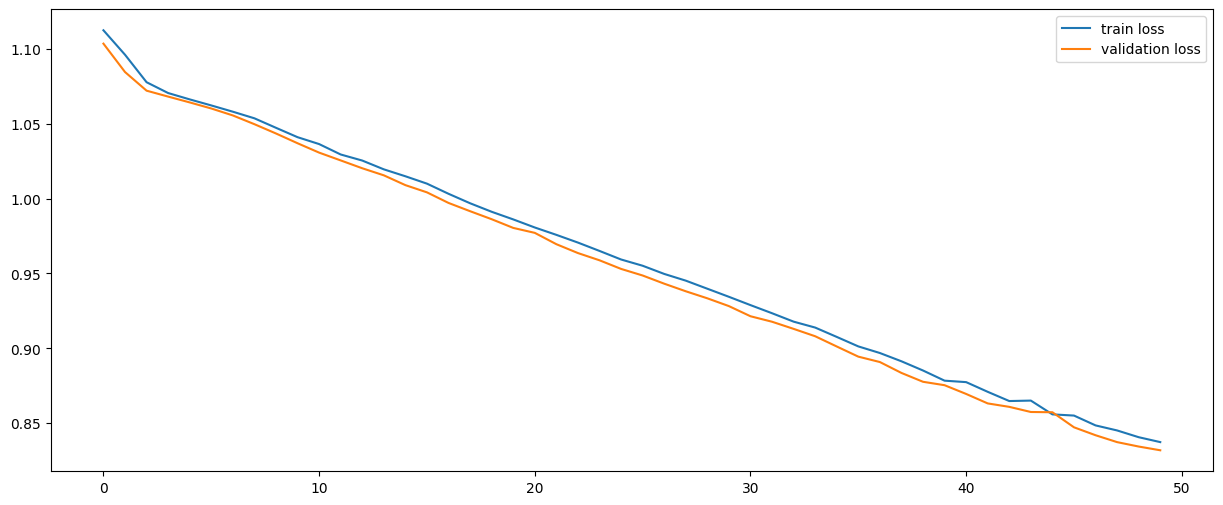

In [38]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

In [39]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.6336854681506634
              precision    recall  f1-score   support

           0     0.5323    0.1182    0.1935      7528
           1     0.6497    0.7785    0.7083     12302
           2     0.6294    0.8090    0.7080     11976

    accuracy                         0.6337     31806
   macro avg     0.6038    0.5686    0.5366     31806
weighted avg     0.6143    0.6337    0.5863     31806



In [40]:
class_summary = df.groupby("Target_100").size().reset_index(name="Count")

# Calculate relative percentage
class_summary["Percent"] = (class_summary["Count"] / class_summary["Count"].sum()) * 100
class_summary["Percent"] = class_summary["Percent"].round(2)


print(class_summary)

   Target_100  Count  Percent
0           0  23170    21.82
1           1  40368    38.02
2           2  42636    40.16
